# Modelo de Red Neuronal para detección y clasificación de tumores #

### Comenzamos importando todas la librerias a usar en el modelo ###

In [66]:
import pandas as pd
import numpy as np
np.random.seed(0)
seed = 0
import warnings
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm
plt.style.use("dark_background")
#plt.style.use("grayscale")

### Carguemos la base de datos del MIT

In [112]:
import cv2

IMG_SIZE = 255
x_train = []
y_label = []

# Ruta base de la carpeta de datos
data_folder = '/Users/antonio/Desktop/archive'

# Recorre los archivos en la carpeta de datos
for dirname, _, filenames in os.walk(data_folder):
    for filename in filenames:
        # Construye la ruta completa de la imagen
        img_path = os.path.join(dirname, filename)
        
        # Lee la imagen usando OpenCV
        im = cv2.imread(img_path)
        
        # Verifica si la imagen se cargó correctamente
        if im is not None:
            # Cambia el formato de color de BGR a RGB
            img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            
            # Redimensiona la imagen al tamaño deseado
            new_array = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            
            # Determina la etiqueta de la imagen según la carpeta en la que se encuentra
            if 'no_tumor' in dirname:
                y_label.append(0)
            elif 'glioma_tumor' in dirname:
                y_label.append(1)
            elif 'meningioma_tumor' in dirname:
                y_label.append(2)
            elif 'pituitary_tumor' in dirname:
                y_label.append(3)
            
            # Agrega la imagen redimensionada a la lista de datos de entrenamiento
            x_train.append(new_array)
        else:
            print("No se pudo cargar la imagen:", img_path)

# Convertir las listas en matrices numpy
x_train = np.array(x_train)
y_label = np.array(y_label)



No se pudo cargar la imagen: /Users/antonio/Desktop/archive/.DS_Store
No se pudo cargar la imagen: /Users/antonio/Desktop/archive/Training/.DS_Store
No se pudo cargar la imagen: /Users/antonio/Desktop/archive/Testing/.DS_Store


In [113]:
x_train = np.array(x_train)
x_train.shape

(3264, 255, 255, 3)

In [114]:
y_label = np.array(y_label)
y_label = pd.get_dummies(y_label)
y_label.shape

(3264, 4)

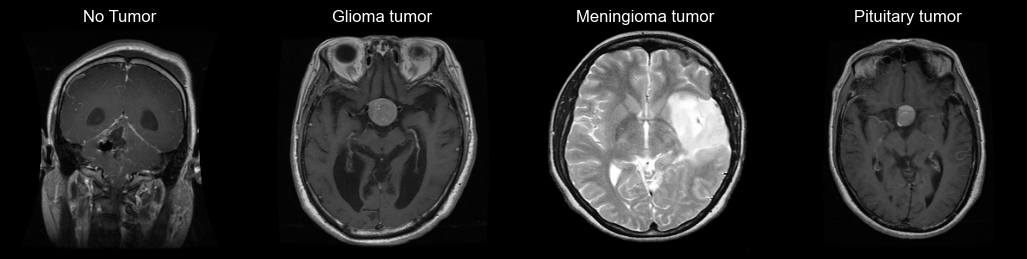

In [115]:
fig, axes = plt.subplots(ncols=4, figsize=(13,6))
title = ["No Tumor",
         "Glioma tumor",
         "Meningioma tumor",
         "Pituitary tumor"]
for i in range(4):
    rand_ind = np.random.randint(0, y_label[y_label==i].shape[0])
    axes[i].imshow(x_train[rand_ind])
    axes[i].set_title(title[i])
    axes[i].axis('off')

In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    x_train, y_label, test_size=0.3, random_state=seed
)

In [117]:
X_train.shape

(2284, 255, 255, 3)

### Visualización de los datos que tenemos en el dataset

In [110]:
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

X_train1 = []
y_train1 = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

folder_base =  '/Users/antonio/Desktop/archive'


image_size = 150
for i in labels:
    folderPath = os.path.join(folder_base,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train1.append(img)
        y_train1.append(i)
        
for i in labels:
    folderPath = os.path.join(folder_base, 'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train1.append(img)
        y_train1.append(i)
        
X_train1 = np.array(X_train)
y_train1 = np.array(y_train1)


  0%|          | 0/826 [00:00<?, ?it/s]

100%|██████████| 74/74 [00:00<00:00, 108.65it/s]


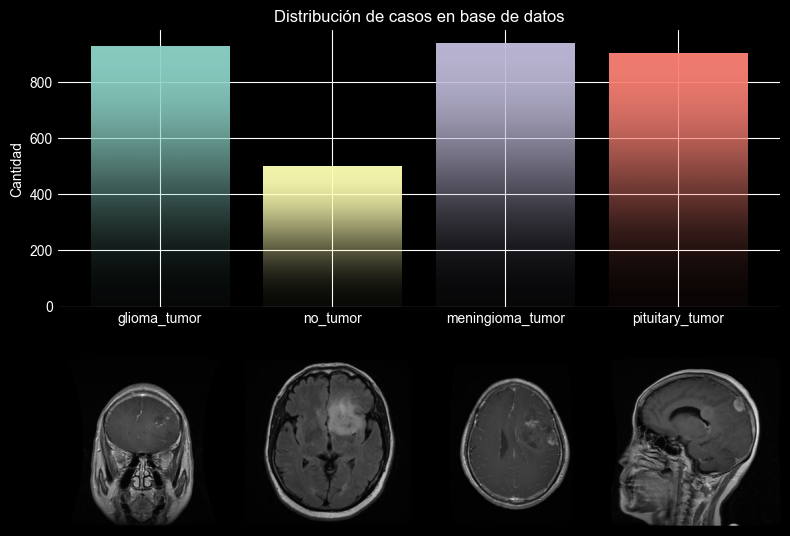

In [111]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train1 == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Cantidad')
plt.title('Distribución de casos en base de datos')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train1[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train1[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

### Preparar los datos para usar funciones

In [134]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest'
                                  )

for i in range(0,2284):
    img_tensor = np.expand_dims(X_train[i], axis=0)
    pic = train_datagen.flow(img_tensor,batch_size =1, seed=0)
    batch = next(pic)
    image_ = batch[0].astype('uint8')
    X_train = np.append(X_train, [image_], axis=0)
print(image_.shape)



(255, 255, 3)


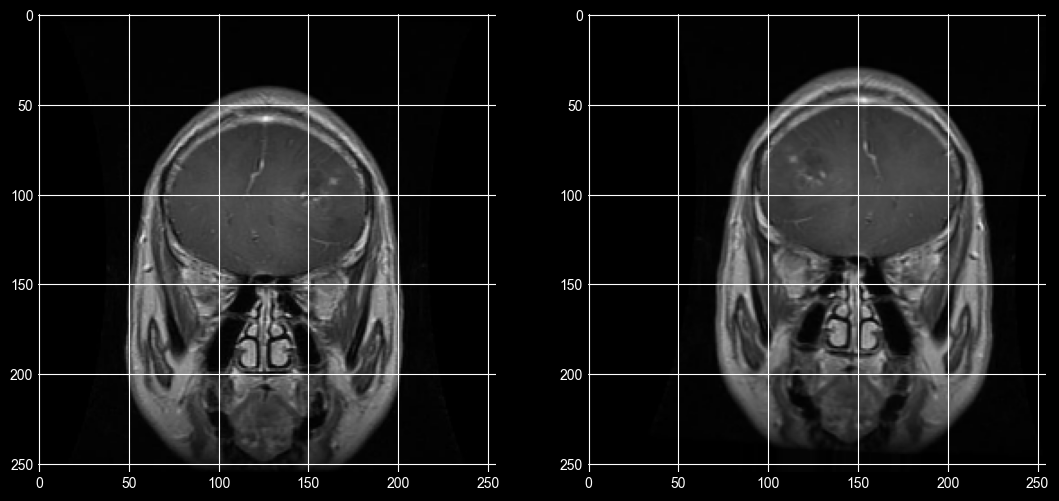

In [141]:
fig, axes = plt.subplots(ncols=2, figsize=(13,6))
axes[0].imshow(X_train[0])
axes[1].imshow(X_train[0+2284])

In [142]:
y_train = pd.concat([y_train,y_train])
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_train


TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

### Crear Modelo de Red Neuronal usando TensorFlow

In [143]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 255*255*3))
X_test_reshaped = X_test.reshape((X_test.shape[0], 255*255*3))
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train_reshaped)
X_test_transformed = scaler.transform(X_test_reshaped)

In [144]:
P = PCA(n_components = 200)
pca_train = P.fit_transform(X_train_transformed)
pca_test = P.transform(X_test_transformed)

In [145]:
np.sum(P.explained_variance_ratio_)

0.7946921881505635

Text(0, 0.5, 'Fracción de varianza total explicada')

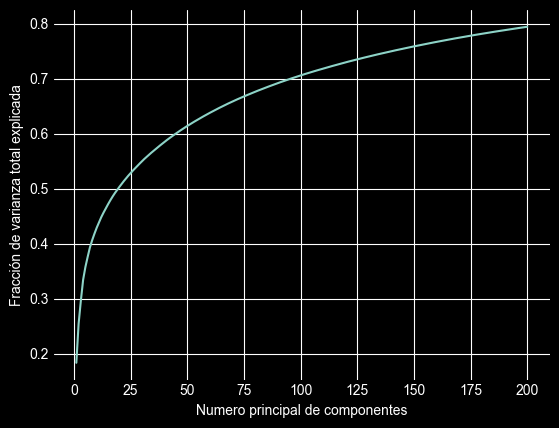

In [146]:
f,ax = plt.subplots()
list1 = []
sum = 0

for i in P.explained_variance_ratio_:
  sum = sum + i
  list1.append(sum)

plt.plot(range(1,201),list1)
ax.set_xlabel("Numero principal de componentes")
ax.set_ylabel("Fracción de varianza total explicada")

In [147]:
P = PCA(n_components = 100)
pca_train = P.fit_transform(X_train_transformed)
pca_test = P.transform(X_test_transformed)

In [148]:
np.sum(P.explained_variance_ratio_)

0.7059730128902344

In [151]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_validate, cross_val_score

print("Tamaño de X_train_transformed:", X_train_transformed.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de X_test_transformed:", X_test_transformed.shape)
print("Tamaño de y_test:", y_test.shape)


Tamaño de X_train_transformed: (4568, 195075)
Tamaño de y_train: (4568, 4)
Tamaño de X_test_transformed: (980, 195075)
Tamaño de y_test: (980, 4)


In [152]:
clf = MLPClassifier()
clf.fit(pca_train, y_train)

MLPClassifier()

In [153]:
print(clf.score(pca_train, y_train))

0.9973730297723292


In [154]:
print(clf.score(pca_test, y_test))

0.7346938775510204


In [155]:
from sklearn.model_selection import GridSearchCV
perceptron = MLPClassifier(max_iter=1500)
parameter_space = {
    'hidden_layer_sizes': [(40, 35,), (30, 20, 15),(40,35,20), (20, 25, 15,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': np.linspace(0.0001, 0.1, 10),
    'learning_rate': ['adaptive'],
}
clf = GridSearchCV(perceptron, parameter_space, n_jobs=-1, cv=5)
clf

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1500), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': array([0.0001, 0.0112, 0.0223, 0.0334, 0.0445, 0.0556, 0.0667, 0.0778,
       0.0889, 0.1   ]),
                         'hidden_layer_sizes': [(40, 35), (30, 20, 15),
                                                (40, 35, 20), (20, 25, 15)],
                         'learning_rate': ['adaptive'], 'solver': ['adam']})

In [156]:
clf.fit(pca_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1500), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': array([0.0001, 0.0112, 0.0223, 0.0334, 0.0445, 0.0556, 0.0667, 0.0778,
       0.0889, 0.1   ]),
                         'hidden_layer_sizes': [(40, 35), (30, 20, 15),
                                                (40, 35, 20), (20, 25, 15)],
                         'learning_rate': ['adaptive'], 'solver': ['adam']})

In [157]:
print('Mejores parámetros encontrados:\n', clf.best_params_)

Mejores parámetros encontrados:
 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (40, 35, 20), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [159]:

ML = MLPClassifier(hidden_layer_sizes = [40,35,20], max_iter = 1500, activation = 'relu',
                  alpha= 0.0889, learning_rate = 'adaptive', solver = 'adam')
clf1 = ML.fit(pca_train, y_train)

In [161]:
train_scores = clf1.score(pca_train, y_train)
test_scores = clf1.score(pca_test, y_test) 

print(f"Precisión de entrenamiento...{train_scores}")
print(f"Precisión de testeo...{test_scores}")

Precisión de entrenamiento...0.9697898423817863
Precisión de testeo...0.7408163265306122


In [162]:
y_pred_new = clf1.predict(pca_test)
arr = []
for item in y_pred_new:
    result = np.where(item == np.amax(item))
    arr.append(result[0][0])
y_pred_new = np.array(arr)
y_pred_new = pd.get_dummies(y_pred_new)
y_pred_new

,0,1,2,3
0,False,False,False,True
1,False,False,True,False
2,False,False,True,False
3,False,True,False,False
4,False,True,False,False
...,...,...,...,...
975,False,True,False,False
976,False,False,True,False
977,False,False,True,False
978,False,False,True,False


In [163]:
y_pred_new = y_pred_new.idxmax(axis=1)
y_test_new = pd.DataFrame(y_test)
y_test_new = y_test_new.idxmax(axis=1)

In [164]:
print(classification_report(np.array(y_test_new), np.array(y_pred_new), target_names=["No Tumor",
                                                                                      "Glioma Tumor",
                                                                                      "Meningioma tumor",
                                                                                      "Pituitary tumor"]))

                  precision    recall  f1-score   support

        No Tumor       0.60      0.90      0.72       131
    Glioma Tumor       0.79      0.77      0.78       278
Meningioma tumor       0.82      0.68      0.74       318
 Pituitary tumor       0.91      0.90      0.91       253

        accuracy                           0.79       980
       macro avg       0.78      0.81      0.79       980
    weighted avg       0.81      0.79      0.79       980



### Entrenamiento en Keras

In [166]:
IMG_SIZE = 255
import tensorflow.keras as keras
model_mobilenet = keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

/var/folders/1v/dh72m30s377gjf7zw07mqrhw0000gn/T/ipykernel_23183/2797264495.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model_mobilenet = keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)